# Calibration de modèles GARCH par des méthodes d'apprentissage
---

## Rappels
---

On a :
$$ \sigma_t^2 = \alpha_0 + \alpha_1  x_{t-1}^2 + \beta_1 \sigma_{t-1}^2$$
avec $x_t = \sigma_t Z_t$

## I - Installation des modules
---

In [73]:
# Gestion des modules et des imports

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import random
import statsmodels

from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## II - Mise en place du réseau de neurones
---

On met en place un réseau de neurones à 5 couches :
- une couche d'entrée prenant pour 4 entrées les moments d'ordre 2,4 et 6 ainsi que l'autocovariance pour un lag n = 2.
- une première couche cachée comportant 64 neurones.
- une deuxième couche cachée comportant 128 neurones.
- une troisième couche cachée comportant 64 neurones.
- une couche de sortie a un paramètre.

On utilise des fonctions d'activations ReLU et l'erreur quadratique moyenne comme fonction de perte

In [74]:
# Définition du réseau de neurones

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(6, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = self.layer5(x)
        return x
    
    def save(self, path):
        torch.save(self.state_dict(), path)
    
    def load(self, path):
        self.load_state_dict(torch.load(path))

# Instanciation du réseau
net = NeuralNetwork()

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.MSELoss()  # Exemple de fonction de perte (erreur quadratique moyenne)
# Optimiseur (Adam)
optimizer = optim.Adam(net.parameters(), lr=0.001)



On définit des fonctions qui déterminent à partir des coefficients $\alpha_0, \alpha_1$ et $\beta_1$ les valeurs des moments normalisés d'odre $2,4$ et $6$ et le $\gamma_2$ du modèle GARCH correspondant.

In [75]:
# Génération des moments d'odre 2,4 et 6 et des lags

def moments(a0,a1,b1):
    M2 = a0/(1-a1-b1)
    M4 = 3 + 6*a1**2/(1-3*a1**2-2*a1*b1-b1**2)
    M6 = 15*(1-a1-b1)**3*(1+3*(a1+b1)/(1-a1-b1)+3*(1+2*(a1+b1)/(1-a1-b1)*(b1**2+2*a1*b1+3*a1**2)/(1-3*a1**2-2*a1*b1-b1**2)))/(1-15*a1**3-9*a1**2*b1-3*a1*b1**2-b1**3)
    return M2, M4, M6

def autocovariance(a0,a1,b1,n=2):
    gamma = 2*a1*(1-a1*b1-b1**2)*(a1+b1)**(n-1)/(1-3*a1**2-2*a1*b1-b1**2)
    return gamma

On crée une fonction qui génère des coefficients aléatoires puis calcule les moments d'ordre 2, 4 et 6 ainsi que le lag associé.

## III - Entrainement du réseau de neurones
---

In [76]:
# Génération des données d'entrainement

def sigmoid(x):
    return 1/(1+np.exp(-x))

def generate_data(num_samples):
    # Créer des listes pour stocker les données
    inputs = []
    targets = []

    # Générer les données d'entrainement
    for _ in range(num_samples):
        # Générer des paramètres aléatoires pour a0, a1 et b1
        a0 = np.random.rand()*10**(-3) + 10**(-6)
        a1 = np.random.rand()*0.3
        b1 = np.random.rand()
        
        # Calculer les valeurs de sortie en utilisant la fonction f
        y1, y2, y3 = moments(a0, a1, b1)
        y4 = autocovariance(a0, a1, b1, 2)
        y5 = autocovariance(a0, a1, b1, 4)
        y6 = autocovariance(a0, a1, b1, 6)

        # Ajouter les paramètres et les valeurs de sortie aux listes
        inputs.append([y1, y2, y3, y4, y5, y6])
        targets.append([a1, b1])

    # Convertir les listes en tenseurs PyTorch
    return nn.functional.normalize(torch.tensor(inputs, dtype=torch.float32)), torch.tensor(targets, dtype=torch.float32)

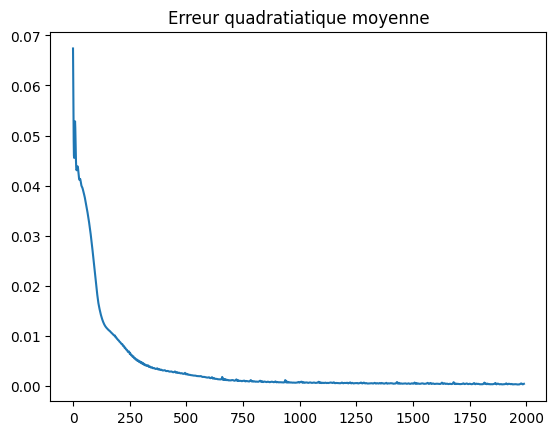

In [77]:
# Boucle d'entrainement

nbrBoucle = 2000
bachSize = 500
inputs_tensor, targets_tensor = generate_data(bachSize)

error = []

for epoch in range(nbrBoucle): 
    optimizer.zero_grad()  # Réinitialiser les gradients
    
    # Passage avant dans le réseau
    outputs = net(inputs_tensor)

    # Calcul de la perte
    loss = criterion(outputs, targets_tensor)
    
    # Calcul des gradients et mise à jour des poids
    loss.backward()
    optimizer.step()
    error.append(loss.item())

    # Affichage de la progression
    percent = (epoch+1) / nbrBoucle
    bar = "█" * int(30*percent) + " " * (30 - int(30*percent))
    progressBar = f"\r Progress : |{bar}| - {100*percent:.2f}% - Erreur : {100*loss.item():.4f} - Nombre d'époques : {epoch+1}"
    print(progressBar, end="\r")

plt.plot(error[10:])
plt.title("Erreur quadratiatique moyenne")
plt.show()


## IV - Analyse des résultats
---

On peut maintenant observer la précision de notre modèle.

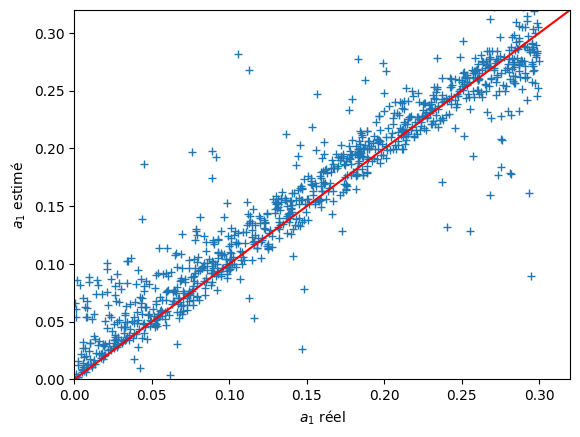

In [78]:
# Affichage des résultats a1

inputs_tensor, targets_tensor = generate_data(1000)
plt.plot(targets_tensor.detach().numpy()[:,0],net(inputs_tensor).detach().numpy()[:,0], marker = '+', linestyle = 'None')
plt.xlabel('$a_1$ réel')
plt.ylabel('$a_1$ estimé')
plt.plot([0,0.5],[0,0.5], color = 'red')
plt.xlim(0,0.32)
plt.ylim(0,0.32)
plt.show()

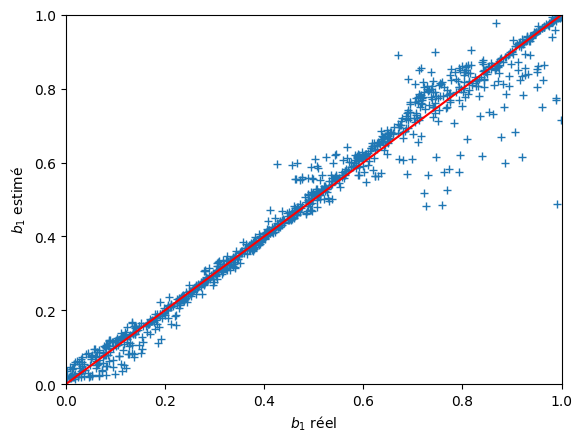

In [79]:
# Affichage des résultats b1

inputs_tensor, targets_tensor = generate_data(1000)
plt.plot(targets_tensor.detach().numpy()[:,1],net(inputs_tensor).detach().numpy()[:,1], marker = '+', linestyle = 'None')
plt.xlabel('$b_1$ réel')
plt.ylabel('$b_1$ estimé')
plt.plot([0,1],[0,1], color = 'red')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [80]:
# Sauvegarde du modèle

heure = datetime.now().strftime("%Y-%m-%d %H-%M-%S")

#net.save(f'model{heure}.pt')

## V - Estimation des coefficients à partir d'un signal
---

On cherche ici à évaluer le modèle en conditions "réelles". On génère des signaux temporels suivant un modèle GARCH(1,1) et on cherche à évaluer les coefficients a posteriori. On trace ensuite les points $(a_1,b_1)$ pour évaluer la précision de notre modèle. 

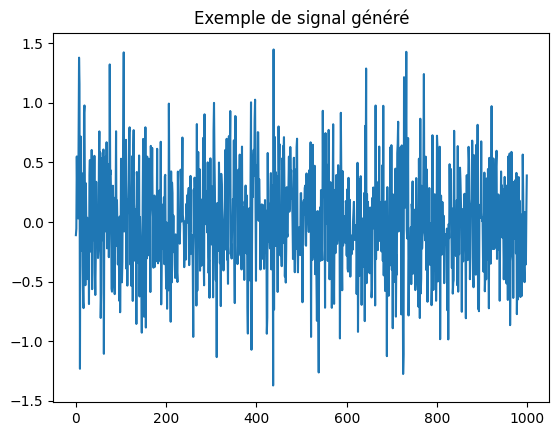

In [81]:
# Génération de données de test et estimation des moments

def signal(n, a0, a1, b1):
    signalTab = np.zeros(n)
    sigma = a0
    signalTab[0] = a0 * np.random.normal(0, 1)
    for i in range(1, n):
        sigma = np.sqrt(a0 + a1 * signalTab[i-1]**2 + b1 * sigma**2)
        signalTab[i] = sigma * np.random.normal(0, 1)
    return signalTab

def estimateMoments(signalTab):
    n = len(signalTab)
    y1 = signalTab.var()
    y2 = ((signalTab - signalTab.mean())**4).mean()/y1**2
    y3 = ((signalTab - signalTab.mean())**6).mean()/y1**3
    y4 = np.cov(signalTab[:-2], signalTab[2:])[0,1]/y1
    y5 = np.cov(signalTab[:-4], signalTab[4:])[0,1]/y1
    y6 = np.cov(signalTab[:-6], signalTab[6:])[0,1]/y1
    return torch.tensor([[y1, y2, y3, y4, y5, y6]],dtype = torch.float32)

plt.plot(signal(1000, 0.1, 0.2, 0.3))
plt.title("Exemple de signal généré")
plt.show()

Comme on peut le voir sur le graphique ci-dessous, le modèle parvient à évaluer $b_1$ avec une précision relativement bonne. En revanche, l'estimation de $a_1$ est très mauvaise.\
En pratique, il apparait que les moments empiriques d'ordre $2,4$ et $6$ sont très proches des valeurs théoriques mais que les autocovariances ne sont pas précises ce qui pourrait expliquer ces erreurs.\
On illustre ce phénomène avec les graphes suivants :

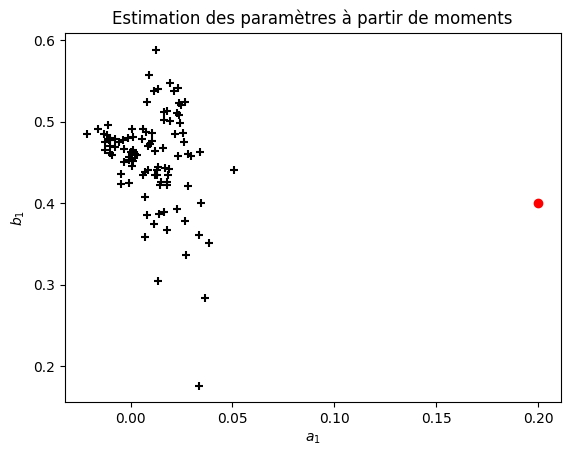

In [82]:
# Vérification de l'estimation des moments

nbrBoucle = 1000


# On veut estimer les paramètres a0, a1 et b1 à partir d'un signal de longueur n = 1000

n = 10000
a0 = 0.0001
a1 = 0.2
b1 = 0.4

for i in range(100):
    signalTab = signal(n, a0, a1, b1)
    y = estimateMoments(signalTab)
    y = nn.functional.normalize(y)
    plt.scatter(net(y).detach().numpy()[0][0],net(y).detach().numpy()[0][1], color = 'black', marker= '+')

plt.scatter(a1,b1,color = 'r')
plt.xlabel('$a_1$')
plt.ylabel('$b_1$')
plt.title("Estimation des paramètres à partir de moments")
plt.show()


On cherche à étudier la précision des moments empiriques.

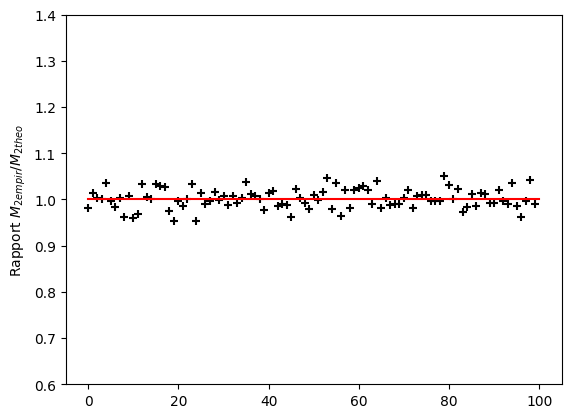

In [83]:
# Comparaison entre les moments théoriques et empiriques

n = 10000
a0 = 0.0001
a1 = 0.2
b1 = 0.4


y1, y2, y3 = moments(a0, a1, b1)
y4 = autocovariance(a0, a1, b1, 2)
y5 = autocovariance(a0, a1, b1, 4)
y6 = autocovariance(a0, a1, b1, 6)

for i in range(100):
    signalTab = signal(n, a0, a1, b1)
    y = estimateMoments(signalTab)
    plt.scatter(i,y[0][0]/y1, color = 'black', marker= '+')

plt.plot([0,100],[1,1],color = 'r')
plt.ylabel('Rapport $M_{2empir}/M_{2theo}$')
plt.ylim(0.6,1.4)
plt.show()

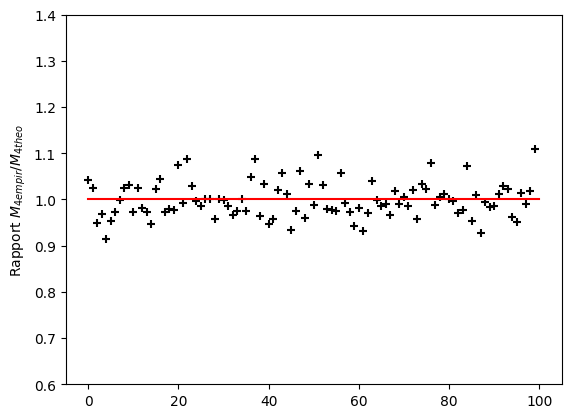

In [84]:
# Comparaison entre les moments théoriques et empiriques

n = 10000
a0 = 0.0001
a1 = 0.2
b1 = 0.4


y1, y2, y3 = moments(a0, a1, b1)
y4 = autocovariance(a0, a1, b1, 2)
y5 = autocovariance(a0, a1, b1, 4)
y6 = autocovariance(a0, a1, b1, 6)

for i in range(100):
    signalTab = signal(n, a0, a1, b1)
    y = estimateMoments(signalTab)
    plt.scatter(i,y[0][1]/y2, color = 'black', marker= '+')

plt.plot([0,100],[1,1],color = 'r')
plt.ylabel('Rapport $M_{4empir}/M_{4theo}$')
plt.ylim(0.6,1.4)
plt.show()

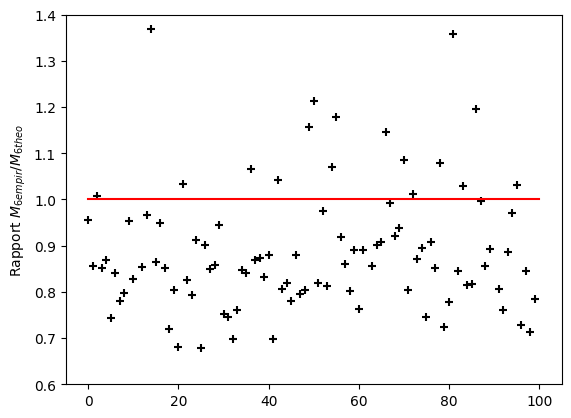

In [85]:
# Comparaison entre les moments théoriques et empiriques

n = 10000
a0 = 0.0001
a1 = 0.2
b1 = 0.4


y1, y2, y3 = moments(a0, a1, b1)
y4 = autocovariance(a0, a1, b1, 2)
y5 = autocovariance(a0, a1, b1, 4)
y6 = autocovariance(a0, a1, b1, 6)

for i in range(100):
    signalTab = signal(n, a0, a1, b1)
    y = estimateMoments(signalTab)
    plt.scatter(i,y[0][2]/y3, color = 'black', marker= '+')

plt.plot([0,100],[1,1],color = 'r')
plt.ylabel('Rapport $M_{6empir}/M_{6theo}$')
plt.ylim(0.6,1.4)
plt.show()

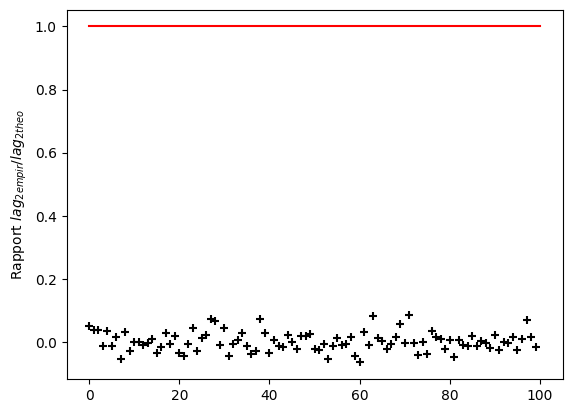

In [86]:
# Comparaison entre les moments théoriques et empiriques

n = 10000
a0 = 0.0001
a1 = 0.2
b1 = 0.4


y1, y2, y3 = moments(a0, a1, b1)
y4 = autocovariance(a0, a1, b1, 2)
y5 = autocovariance(a0, a1, b1, 4)
y6 = autocovariance(a0, a1, b1, 6)

for i in range(100):
    signalTab = signal(n, a0, a1, b1)
    y = estimateMoments(signalTab)
    plt.scatter(i,y[0][3]/y4, color = 'black', marker= '+')

plt.plot([0,100],[1,1],color = 'r')
plt.ylabel('Rapport $lag_{2empir}/lag_{2theo}$')

plt.show()

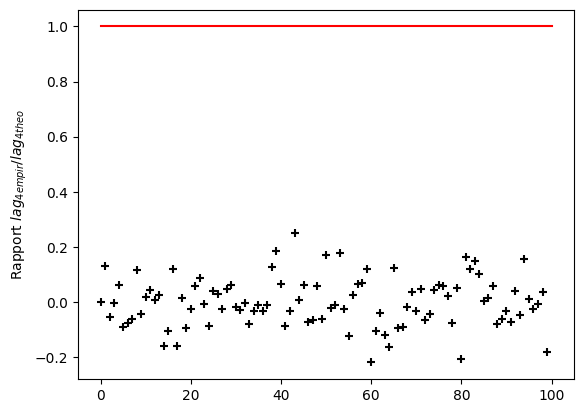

In [87]:
# Comparaison entre les moments théoriques et empiriques

n = 10000
a0 = 0.0001
a1 = 0.2
b1 = 0.4


y1, y2, y3 = moments(a0, a1, b1)
y4 = autocovariance(a0, a1, b1, 2)
y5 = autocovariance(a0, a1, b1, 4)
y6 = autocovariance(a0, a1, b1, 6)

for i in range(100):
    signalTab = signal(n, a0, a1, b1)
    y = estimateMoments(signalTab)
    plt.scatter(i,y[0][4]/y5, color = 'black', marker= '+')

plt.plot([0,100],[1,1],color = 'r')
plt.ylabel('Rapport $lag_{4empir}/lag_{4theo}$')

plt.show()

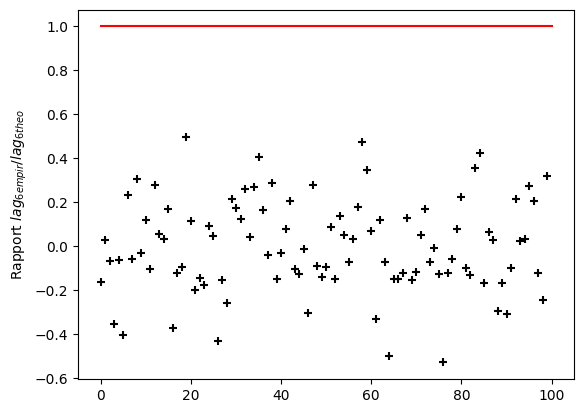

In [88]:
# Comparaison entre les moments théoriques et empiriques

n = 10000
a0 = 0.0001
a1 = 0.2
b1 = 0.4


y1, y2, y3 = moments(a0, a1, b1)
y4 = autocovariance(a0, a1, b1, 2)
y5 = autocovariance(a0, a1, b1, 4)
y6 = autocovariance(a0, a1, b1, 6)

for i in range(100):
    signalTab = signal(n, a0, a1, b1)
    y = estimateMoments(signalTab)
    plt.scatter(i,y[0][5]/y6, color = 'black', marker= '+')

plt.plot([0,100],[1,1],color = 'r')
plt.ylabel('Rapport $lag_{6empir}/lag_{6theo}$')

plt.show()

## Idées d'améliorations
---

Idée 1 :\
Entrainer le réseau de neurones directement à partir de valeurs empiriques 
Les + : potentiellement plus de précisions
Les - : beaucoup plus de calculs, on perd l'intérêt de la méthode proposé.


Idée 2 :\
Faire un deuxième réseau pour déterminer les moments théoriques à partir des moments empiriques.
Les + : potentiellement plus de précisions et cela permet de factoriser le processus en deux étapes.
Les - : beaucoup plus de calculs, pas forcément plus efficace que l'idée 1.

Idée 3 :\
